## Import Libraries

In [85]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# %matplotlib inline

<hr>

## Load and Inspect Data

In [2]:
data = pd.read_csv("insurance.txt")
data.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
data.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<hr>

## Preprocess Data

__The purpose of the following preprocessing is to demonstrate that the employed method is functioning correctly. However, while building regression models, the training and testing datasets are standardised separately to prevent data leakage.__

In [6]:
column_names = list(data.columns)
standardize = lambda x : (x - x.mean()) / x.std() 

__Standardize Data__

In [7]:
for column in column_names:
    if column == "charges":
        continue
    data[column] = standardize(data[column])

In [8]:
data.mean()

age        -1.246304e-16
bmi        -1.810543e-16
children   -3.116590e-16
charges     1.327042e+04
dtype: float64

Although standardised mean should be equal to 0, in reality they are infinitesimally close to zero. Double precision floats have 53 bits or 16 digits of precision, so this is expected behavior.

In [9]:
data.std()

age             1.000000
bmi             1.000000
children        1.000000
charges     12110.011237
dtype: float64

In [10]:
x1, x2, x3, y = data["age"], data["bmi"], data["children"], data["charges"]

<hr>

## Visualize Data

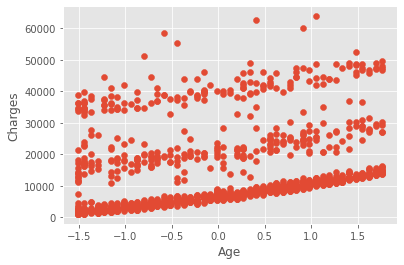

In [151]:
plt.scatter(x1, y)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.savefig("charges_age.jpeg");

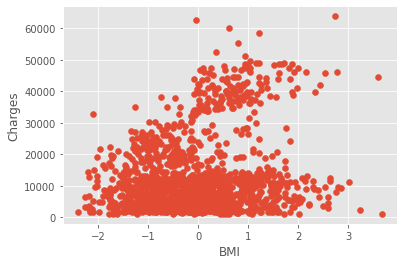

In [152]:
plt.scatter(x2, y)
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.savefig("charges_bmi.jpeg");

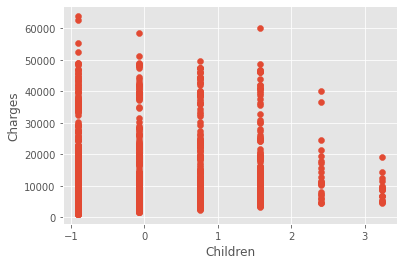

In [154]:
plt.scatter(x3, y)
plt.xlabel("Children")
plt.ylabel("Charges")
plt.savefig("charges_children.jpeg");

<hr>

## Linear Regression Class

In [115]:
class LinearRegression:
    def __init__(self, data):
        self.data = data
        self.models1 = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error"])
        self.models2 = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
        self.models3 = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
        self.errors2 = []
        self.errors3 = []
    
    # shuffles data randomly
    def shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for column in column_names:
            if column == "charges":
                continue
            data[column] = standardize(data[column])
        return data
    
    # computes and returns X and Y matrices
    def matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1, x2, x3= np.array(x1), np.array(x2), np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape((n, 1))
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # Sum of Squares of Error Function
    def error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        sose = (1/2) * np.sum(np.square(Y_pred-Y))
        return float(sose)
    
    # tests the model against testing data
    def testModel(self, test, w):
        Xt, Yt = self.matrices(test)
        testing_error = self.error(Xt, Yt, w)
        return testing_error
           
    # Performs Linear Regression by Normal Equations and returns corresponding Regression Weights
    def solve(self, X, Y):
        XT = np.transpose(X)
        A = XT.dot(X)
        A_inv = np.linalg.inv(A)
        b = XT.dot(Y)
        w = A_inv.dot(b)
        return w

    # Implements Gradient Descent Algorithm
    def gradientDescent(self, X, Y, w, learning_rate = 1e-7):
        i = 1
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-5:
            prev_error = error
            Y_pred = X.dot(w)
            gradient = np.dot(X.transpose(), Y_pred- Y)
            w -= learning_rate * gradient
            error = self.error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i

    # Implements Stochastic Gradient Descent Algorithm
    def stochasticGradientDescent(self, X, Y, w, learning_rate = 1e-5):
        m, i = len(Y), 0
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-2:
            prev_error = error
            x = X[i%m].reshape(1, 4)
            y = Y[i%m].reshape(1, 1)
            y_pred = x.dot(w)
            gradient = np.dot(x.transpose(), y_pred- y)
            w -= learning_rate * gradient
            error = self.error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i + 1

    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            self.shuffle()                                                                  # shuffle dataset
            train, test = self.split()                                                      # split dataset
            train = self.standardize(train)                                                 # standardise training data
            test = self.standardize(test)                                                   # standardise testing data
            X, Y = self.matrices(train)                                                     # obtain X and Y matrices
            w1 = self.solve(X, Y)                                                           # regression by normal equations
            w2 = np.random.rand(4, 1)                                                       # generate random weights w for grad. desc.
            w2, model_errors2 , iterations2 = self.gradientDescent(X, Y, w2)                # regression by gradient descent
            w3 = np.random.rand(4, 1)                                                       # generate random weights w for st. grad. desc.
            w3, model_errors3 , iterations3 = self.stochasticGradientDescent(X, Y, w3)      # regression by stochastic grad. desc.
            training_error1 = self.error(X, Y, w1)                                          # calculate training error
            training_error2 = self.error(X, Y, w2)                                          # calculate training error
            training_error3 = self.error(X, Y, w3)                                          # calculate training error
            testing_error1 = self.testModel(test, w1)                                       # calculate testing error
            testing_error2 = self.testModel(test, w2)                                       # calculate testing error
            testing_error3 = self.testModel(test, w3)                                       # calculate testing error
            # append the model, errors to models dataframe
            model1 = list(w1)
            model2 = list(w2)
            model3 = list(w3)
            model1.append(testing_error1)
            model2.append(testing_error2)
            model3.append(testing_error3)
            model1.append(training_error1)
            model2.append(training_error2)
            model3.append(training_error3)
            model2.append(iterations2)
            model3.append(iterations3)
            model1 = pd.Series(model1, index = self.models1.columns)
            model2 = pd.Series(model2, index = self.models2.columns)
            model3 = pd.Series(model3, index = self.models3.columns)
            self.models1 = self.models1.append(model1, ignore_index=True)
            self.models2 = self.models2.append(model2, ignore_index=True)
            self.models3 = self.models3.append(model3, ignore_index=True)
            self.errors2.append(model_errors2)
            self.errors3.append(model_errors3)

<hr>

## Build Regression Models

In [116]:
data = pd.read_csv("insurance.txt")

In [117]:
lr_models = LinearRegression(data)
lr_models.buildModels(20)

#### Linear Regression Models - Normal Equations

In [118]:
lr_models.models1

,w0,w1,w2,w3,testing_error,training_error
0,[13575.259360650643],[3083.941352260557],[2275.8417312163047],[612.8965857808448],2.527376e+10,6.117133e+10
1,[13702.237742318375],[3356.852682027966],[2555.9634767820476],[659.964645534041],2.375120e+10,6.281277e+10
2,[13158.975150821576],[3566.383492565934],[2053.8352951608235],[778.720691761744],2.772058e+10,5.858356e+10
3,[13093.714879229698],[3742.8987930669464],[1702.017091055805],[960.63722091569],2.940431e+10,5.704414e+10
4,[12857.346835116461],[3758.420466538567],[1620.2550175121905],[342.57798384042525],3.034175e+10,5.620226e+10
5,[13053.28046895192],[3455.8728571476195],[1881.2998321441607],[511.8434499734846],2.766962e+10,5.855535e+10
6,[13163.152730287406],[3519.1723654932953],[2155.7819559555414],[768.8394770028383],2.535184e+10,6.091743e+10
7,[13597.010758557693],[3429.554943033325],[1946.9895607873596],[795.4142523198476],2.185061e+10,6.449712e+10
8,[13067.495911324788],[3513.032904750682],[1766.9016344564236],[841.2773655440684],2.686299e+10,5.954564e+10
9,[12764.384152285253],[3429.476793576131],[1636.776017153904],[440.7863045004934],3.080021e+10,5.584986e+10


#### Linear Regression Models - Gradient Descent

In [119]:
lr_models.models2

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[13575.243952515384],[3083.9384092142554],[2275.8432051660006],[612.8976672406633],2.527375e+10,6.117133e+10,146242
1,[13702.221593669907],[3356.8498272368747],[2555.964420576078],[659.9655265521477],2.375119e+10,6.281277e+10,145840
2,[13158.960583766191],[3566.378801150959],[2053.8381794816796],[778.7224192763],2.772058e+10,5.858356e+10,146509
3,[13093.700830777254],[3742.8925778275407],[1702.022115257907],[960.6366424398798],2.940431e+10,5.704414e+10,146843
4,[12857.333735519855],[3758.412805870167],[1620.26098316494],[342.5800093323637],3.034175e+10,5.620226e+10,147396
5,[13053.265945316352],[3455.8673637338093],[1881.3039576922338],[511.84498137583574],2.766962e+10,5.855535e+10,146455
6,[13163.137929721335],[3519.1669901232904],[2155.7852214675695],[768.842139229553],2.535184e+10,6.091743e+10,146343
7,[13596.994873752448],[3429.5513370698563],[1946.9911200601427],[795.4149562764295],2.185060e+10,6.449712e+10,145934
8,[13067.481569225329],[3513.0276790433495],[1766.9055058963559],[841.2785509245981],2.686299e+10,5.954564e+10,146601
9,[12764.368920556497],[3429.4716915394424],[1636.7794726896561],[440.78726788367953],3.080021e+10,5.584986e+10,145707


#### Linear Regression Models - Stochastic Gradient Descent

In [120]:
lr_models.models3

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[13572.984097774186],[3082.775005895236],[2274.661334213778],[614.7457957842397],2.527280e+10,6.117133e+10,867697
1,[13698.201167968644],[3354.3291010146013],[2557.3036373750197],[660.9121020186442],2.374967e+10,6.281278e+10,784406
2,[13156.058751892435],[3564.7834454113586],[2054.835650591244],[780.3137560034897],2.772094e+10,5.858357e+10,818333
3,[13089.487397109053],[3740.5076258664403],[1701.5239671697911],[960.777460098444],2.940448e+10,5.704415e+10,801883
4,[12853.578654221265],[3756.1122600821864],[1620.3891294950986],[341.07699889156595],3.034338e+10,5.620227e+10,795649
5,[13031.226730106824],[3450.659074118787],[1883.15734166847],[512.5845675388647],2.767525e+10,5.855559e+10,631270
6,[13159.814024627667],[3516.6233657747725],[2156.307560198926],[767.2505777053568],2.535160e+10,6.091744e+10,805050
7,[13594.084821508519],[3427.4922149228046],[1948.0725130793562],[795.1873535305306],2.184902e+10,6.449713e+10,808363
8,[13062.303632955056],[3512.1588073020052],[1768.5962065785095],[843.4704948941265],2.686427e+10,5.954566e+10,741656
9,[12759.704599972622],[3427.8933775002274],[1636.2508845723412],[439.15018414641816],3.080412e+10,5.584988e+10,815487


### Describe Regression Models

In [122]:
lr_models.models1.describe()

,testing_error,training_error
count,2.000000e+01,2.000000e+01
mean,2.607175e+10,6.034315e+10
std,2.493408e+09,2.475010e+09
min,2.185061e+10,5.584986e+10
25%,2.448209e+10,5.857651e+10
50%,2.591579e+10,6.043458e+10
75%,2.768236e+10,6.187062e+10
max,3.080021e+10,6.449712e+10


In [123]:
lr_models.models2.describe()

,testing_error,training_error
count,2.000000e+01,2.000000e+01
mean,2.607175e+10,6.034315e+10
std,2.493412e+09,2.475010e+09
min,2.185060e+10,5.584986e+10
25%,2.448209e+10,5.857651e+10
50%,2.591580e+10,6.043458e+10
75%,2.768236e+10,6.187062e+10
max,3.080021e+10,6.449712e+10


In [124]:
lr_models.models3.describe()

,testing_error,training_error
count,2.000000e+01,2.000000e+01
mean,2.607194e+10,6.034317e+10
std,2.494857e+09,2.474999e+09
min,2.184902e+10,5.584988e+10
25%,2.448146e+10,5.857657e+10
50%,2.591565e+10,6.043459e+10
75%,2.768667e+10,6.187064e+10
max,3.080412e+10,6.449713e+10


### Mean, Variance and Minimum of Training Error

__Normal Equations__

In [155]:
print(f"Mean of training error obtained over 20 regression models = {lr_models.models1.training_error.mean()}")

Mean of training error obtained over 20 regression models = 60343148245.36564


In [156]:
print(f"Variance of training error obtained over 20 regression models = {lr_models.models1.training_error.var()}")

Variance of training error obtained over 20 regression models = 6.125676045026992e+18


In [157]:
print(f"Minimum training error obtained over 20 regression models = {lr_models.models1.training_error.min()}")

Minimum training error obtained over 20 regression models = 55849864379.25154


__Gradient Descent__

In [158]:
print(f"Mean of training error obtained over 20 regression models = {lr_models.models2.training_error.mean()}")

Mean of training error obtained over 20 regression models = 60343148245.48977


In [159]:
print(f"Variance of training error obtained over 20 regression models = {lr_models.models2.training_error.var()}")

Variance of training error obtained over 20 regression models = 6.125676045042612e+18


In [160]:
print(f"Minimum training error obtained over 20 regression models = {lr_models.models2.training_error.min()}")

Minimum training error obtained over 20 regression models = 55849864379.37653


__Stochastic Gradient Descent__

In [161]:
print(f"Mean of training error obtained over 20 regression models = {lr_models.models3.training_error.mean()}")

Mean of training error obtained over 20 regression models = 60343172601.89815


In [162]:
print(f"Variance of training error obtained over 20 regression models = {lr_models.models3.training_error.var()}")

Variance of training error obtained over 20 regression models = 6.125621830425649e+18


In [163]:
print(f"Minimum training error obtained over 20 regression models = {lr_models.models3.training_error.min()}")

Minimum training error obtained over 20 regression models = 55849877328.86045


### Mean, Variance and Mean of Testing Error

__Normal Equations__

In [164]:
print(f"Mean of testing error obtained over 20 regression models = {lr_models.models1.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 26071746483.02218


In [165]:
print(f"Variance of training error obtained over 20 regression models = {lr_models.models1.testing_error.var()}")

Variance of training error obtained over 20 regression models = 6.217081826684456e+18


In [166]:
print(f"Minimum testing error obtained over 20 regression models = {lr_models.models1.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 21850607942.52415


__Gradient Descent__

In [167]:
print(f"Mean of testing error obtained over 20 regression models = {lr_models.models2.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 26071745191.58776


In [168]:
print(f"Variance of testing error obtained over 20 regression models = {lr_models.models2.testing_error.var()}")

Variance of testing error obtained over 20 regression models = 6.217102077946414e+18


In [169]:
print(f"Minimum testing error obtained over 20 regression models = {lr_models.models2.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 21850600701.38988


__Stochastic Gradient Descent__

In [170]:
print(f"Mean of testing error obtained over 20 regression models = {lr_models.models3.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 26071942065.3881


In [171]:
print(f"Variance of training error obtained over 20 regression models = {lr_models.models3.testing_error.var()}")

Variance of training error obtained over 20 regression models = 6.224311377590369e+18


In [172]:
print(f"Minimum testing error obtained over 20 regression models = {lr_models.models3.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 21849018211.54329


### Plot the Convergence: Error vs Epochs

__Plot of $E(\omega)$ against the number of iterations of Gradient Descent__

In [173]:
errorsGD = np.array(lr_models.errors2, dtype=object)

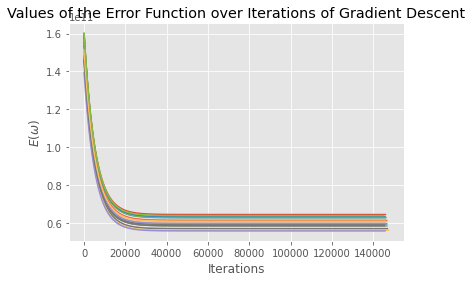

In [174]:
for error in errorsGD:
    plt.plot(error)
    plt.xlabel("Iterations")
    plt.ylabel("$E(\omega)$")
    plt.title("Values of the Error Function over Iterations of Gradient Descent")
plt.savefig("GD_error_epoch.jpeg");

__Plot of $E(\omega)$ against the number of iterations of Stochastic Gradient Descent__

In [175]:
errorsSGD = np.array(lr_models.errors3, dtype=object)

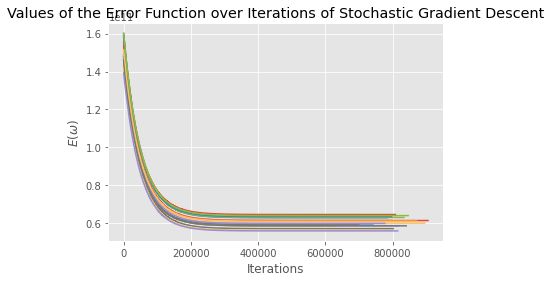

In [176]:
for error in errorsSGD:
    plt.plot(error)
    plt.xlabel("Iterations")
    plt.ylabel("$E(\omega)$")
    plt.title("Values of the Error Function over Iterations of Stochastic Gradient Descent");
plt.savefig("SGD_error_epoch.jpeg")